# SMAC + Meta-Labelling

<div class="alert alert-block alert-info">
<b>Note:</b> The data used in this notebook is sourced from FirstRate Data. To run this notebook, the FirstRate Data, or equivalent data in the same format, is required. </div>

### 1. Imports

In [99]:
# Import packages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pyfolio as pf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils import resample, shuffle
import matplotlib.pyplot as plt
import csv

import os
os.environ['MLFINLAB_API_KEY'] = "e576e4abb9c98802834ca02f123ef4ba"
# Import MlFinLab tools
import mlfinlab as ml

import sys
sys.path.append(os.path.abspath('../pysystemtrade'))

from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
from sysquant.estimators.vol import robust_vol_calc
from systems.accounts.account_forecast import pandl_for_instrument_forecast
%matplotlib inline

### 2. Reading and pre-processing data

In [142]:
CRUDE_OIL = 'CL'
NAT_GAS = 'NG'
BRENT_CRUDE = 'BZ'
GAS = 'RB'
HEAT_OIL = 'HO'

fuel_futures = [CRUDE_OIL, NAT_GAS, BRENT_CRUDE, GAS, HEAT_OIL]

S_P_500 = 'ES'
NASDAQ = 'NQ'
EUROSTOXX = 'FX'
DAX = 'DY'
FT_100 = 'X'

equity_futures = [S_P_500, NASDAQ, EUROSTOXX, DAX, FT_100]

# Compute moving averages
SHORT_LB = 50
LONG_LB = 100

In [101]:
# Define the data paths according to the structure of the project
FUEL_FUTURES_PATH = '../data/fuel_first_rate_data_R_prices.parquet'
EQUITY_FUTURES_PATH = '../data/equity_indices_first_rate_data_R_prices.parquet'

# This is where csv files must be placed for pysystemtrade to access them
CSV_PATH = '../pysystemtrade/data/firstrate_futures/meta-labelling'

In [102]:
# Read in data
start_datetime = '2018-01-02'

fuel_futures_data = pd.read_parquet(FUEL_FUTURES_PATH)
equity_futures_data = pd.read_parquet(EQUITY_FUTURES_PATH)

In [103]:
# Function to convert data in a futures data file into individual csv files
def convert_parquet_to_csv(src_dataframe: pd.DataFrame, dst_path: str, symbols: list) -> None:
    """_summary_

    Args:
        src_path (str): _description_
        dst_path (str): _description_
    """

    for i, column in enumerate(symbols):

        dst_filename = dst_path + f'/{symbols[i]}.csv'

        # Convert column into csv file
        src_dataframe[column].to_csv(dst_filename, header=["price"])

        # Replaces 'Datetime' with 'DATETIME' in csv file to match with pysystemtrade's data
        in_csv_file = open(dst_filename, "r")
        csv_reader = csv.reader(in_csv_file)

        lines = list(csv_reader)
        lines[0][0] = 'DATETIME'  # The cell at (0,0) will always be 'Datetime'

        # Separate file object exclusively for writing
        out_csv_file = open(dst_filename, "w")
        csv_writer = csv.writer(out_csv_file)
        csv_writer.writerows(lines)

        in_csv_file.close()
        out_csv_file.close()

In [115]:
convert_parquet_to_csv(fuel_futures_data, CSV_PATH, fuel_futures)
convert_parquet_to_csv(equity_futures_data, CSV_PATH, equity_futures)

### 3. Fitting the primary model (Simple Moving Average Crossover strategy) and secondary model (Random Forest)

In [105]:
def forecast_smac(price: pd.Series, short_lb: int, long_lb: int):
    """_summary_

    Args:
        price (pd.Series): _description_
        short_lb (int): _description_
        long_lb (int): _description_

    Returns:
        _type_: _description_
    """

    fast_sma = price.rolling(window=short_lb).mean()
    slow_sma = price.rolling(window=long_lb).mean()
    raw_smac = fast_sma - slow_sma
    forecast = raw_smac.where(raw_smac > 0, 1.0)
    forecast = forecast.where(raw_smac < 0, -1.0)
    return forecast

In [106]:
def calc_smac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the smac trading rule forecast, given a price and SMA speeds
    Lfast, Lslow and vol_lookback

    """
    # price: This is the stitched price series
    # We can't use the price of the contract we're trading, or the volatility
    # will be jumpy
    # And we'll miss out on the rolldown. See
    # https://qoppac.blogspot.com/2015/05/systems-building-futures-rolling.html

#     price = price.resample("1B").last()

    if Lslow is None:
        Lslow = 4 * Lfast

    # We don't need to calculate the decay parameter, just use the span
    # directly
    fast_sma = price.rolling(window=Lfast).mean()
    slow_sma = price.rolling(window=Lslow).mean()
    raw_smac = fast_sma - slow_sma
    vol = robust_vol_calc(price.diff())
    forecast = raw_smac.where(raw_smac > 0, 1.0)
    forecast = forecast.where(raw_smac < 0, -1.0)
    return forecast
#     return raw_smac / vol

In [107]:
CLOSE = 'close'
FAST = 'fast'
SLOW = 'slow'
ACTUAL = 'actual'
PRED = 'pred'
BIN = 'bin'
SIDE = 'side'
FORECAST = 'forecast'

In [108]:
def compute_smas(dataframe: pd.DataFrame, short_lb: int, long_lb: int) -> pd.DataFrame:
    '''
    '''
    dataframe[FAST] = dataframe[CLOSE].rolling(window=short_lb).mean()
    dataframe[SLOW] = dataframe[CLOSE].rolling(window=long_lb).mean()
    return dataframe

def compute_primary_signals(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    '''

    # Initialize new column 'side'
    dataframe[SIDE] = np.nan
    
    long_signals = dataframe[FAST] >= dataframe[SLOW] 
    short_signals = dataframe[FAST] < dataframe[SLOW] 
    dataframe.loc[long_signals, SIDE] = 1
    dataframe.loc[short_signals, SIDE] = -1
    
    # Remove Look ahead bias by lagging the signal
    dataframe[SIDE] = dataframe[SIDE].shift(1)
    return dataframe

# Fuel Futures Contracts

In [109]:
train_starttime = '2012-09-30'
train_endtime = '2018-01-01'

In [110]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}

def perform_grid_search(X_data, y_data):
    """
    Function to perform a grid search.
    """
    
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [126]:
def compute_meta_labels(data: pd.DataFrame):
    # Compute daily volatility
    daily_vol = ml.util.get_daily_vol(close=data[CLOSE], lookback=50)

    # Apply Symmetric CUSUM Filter and get timestamps for events
    cusum_events = ml.filters.cusum_filter(data[CLOSE], threshold=daily_vol.mean()*0.5)

    # Compute vertical barrier
    vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data[CLOSE], num_days=1)

    pt_sl = [1,2]
    min_ret = 0.005
    triple_barrier_events = ml.labeling.get_events(close=data[CLOSE],
                                                t_events=cusum_events,
                                                pt_sl=pt_sl,
                                                target=daily_vol,
                                                min_ret=min_ret,
                                                num_threads=3,
                                                vertical_barrier_times=vertical_barriers,
                                                side_prediction=data[SIDE])

    labels = ml.labeling.get_bins(triple_barrier_events, data[CLOSE])
    return labels

In [112]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().dropna()
    
    return daily_rets

In [133]:
def compute_features(data):
    """_summary_

    Args:
        data (_type_): _description_
    """

        # Log Returns
    data['log_ret'] = np.log(data[CLOSE]).diff()

    # Momentum
    data['mom10'] = data[CLOSE].pct_change(periods=10)
    data['mom50'] = data[CLOSE].pct_change(periods=50)
    data['mom100'] = data[CLOSE].pct_change(periods=100)
    data['mom200'] = data[CLOSE].pct_change(periods=200)
    data['mom500'] = data[CLOSE].pct_change(periods=500)

    # Volatility
    data['volatility_50'] = data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
    data['volatility_31'] = data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
    data['volatility_15'] = data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

    # Serial Correlation (Takes about 4 minutes)
    window_autocorr = 50

    data['autocorr_1'] = data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
    data['autocorr_2'] = data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
    data['autocorr_3'] = data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
    data['autocorr_4'] = data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
    data['autocorr_5'] = data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

    # Get the various log -t returns
    data['log_t1'] = data['log_ret'].shift(1)
    data['log_t2'] = data['log_ret'].shift(2)
    data['log_t3'] = data['log_ret'].shift(3)
    data['log_t4'] = data['log_ret'].shift(4)
    data['log_t5'] = data['log_ret'].shift(5)

    return data

    

In [151]:
def run_smac_meta_labelling_fuels(symbols: list):

    accounts = []
    feat_imps = []
    primary_accounts = []

    futures_data = pd.read_parquet('../data/fuel_first_rate_data_R_prices.parquet')

    for i in range(len(symbols)):
        print("--------------------------------------------")
        print(f"COLUMN: {symbols[i]}") 

        instrument_data = csvFuturesSimData(csv_data_paths=dict(csvFuturesAdjustedPricesData="data.firstrate_futures.meta-labelling"))
        data = pd.DataFrame()
        price = instrument_data.get_raw_price(symbols[i])
        data[CLOSE] = price
        data[SIDE] = calc_smac_forecast(price, SHORT_LB, LONG_LB)
        data.columns = [CLOSE, 'forecast']


        account = pandl_for_instrument_forecast(forecast=data['forecast'], price=data[CLOSE])
        plt.figure(figsize=(20,5))
        plt.plot(account.curve())
        plt.show()

        data.columns = [CLOSE, SIDE]

        # Save the raw data
        raw_data = data.copy()

        # Drop the NaN values from our data set
        data.dropna(axis=0, how='any', inplace=True)

        labels = compute_meta_labels(data)

        primary_forecast = pd.DataFrame(labels[BIN])
        primary_forecast[PRED] = 1
        primary_forecast.columns = [ACTUAL, PRED]

        # Performance Metrics
        actual = primary_forecast[ACTUAL]
        pred = primary_forecast[PRED]

        # # Log Returns
        # raw_data['log_ret'] = np.log(raw_data[CLOSE]).diff()

        # # Momentum
        # raw_data['mom10'] = raw_data[CLOSE].pct_change(periods=10)
        # raw_data['mom50'] = raw_data[CLOSE].pct_change(periods=50)
        # raw_data['mom100'] = raw_data[CLOSE].pct_change(periods=100)
        # raw_data['mom200'] = raw_data[CLOSE].pct_change(periods=200)
        # raw_data['mom500'] = raw_data[CLOSE].pct_change(periods=500)

        # # Volatility
        # raw_data['volatility_50'] = raw_data['log_ret'].rolling(window=50, min_periods=50, center=False).std()
        # raw_data['volatility_31'] = raw_data['log_ret'].rolling(window=31, min_periods=31, center=False).std()
        # raw_data['volatility_15'] = raw_data['log_ret'].rolling(window=15, min_periods=15, center=False).std()

        # # Serial Correlation (Takes about 4 minutes)
        # window_autocorr = 50

        # raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
        # raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
        # raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
        # raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
        # raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

        # # Get the various log -t returns
        # raw_data['log_t1'] = raw_data['log_ret'].shift(1)
        # raw_data['log_t2'] = raw_data['log_ret'].shift(2)
        # raw_data['log_t3'] = raw_data['log_ret'].shift(3)
        # raw_data['log_t4'] = raw_data['log_ret'].shift(4)
        # raw_data['log_t5'] = raw_data['log_ret'].shift(5)

        raw_data = compute_features(raw_data)

        # Re compute sides
        raw_data['side'] = np.nan

        raw_data[SIDE] = calc_smac_forecast(price, fast_window, slow_window)

        X = raw_data.loc[labels.index, :]

    # Drop unwanted columns
        X.drop([CLOSE],
               axis=1, inplace=True)

        y = labels[BIN]

        # Split data into training, validation and test sets
        X_training_validation = X['2011-09-01':'2018-01-01']
        y_training_validation = y['2011-09-01':'2018-01-01']
        X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation,
                                                                    test_size=0.15, shuffle=False)
        train_df = pd.concat([y_train, X_train], axis=1, join='inner')

        majority = train_df[train_df[BIN] == 0]
        minority = train_df[train_df[BIN] == 1]

        new_minority = resample(minority, 
                           replace=True,  # Sample with replacement
                           n_samples=majority.shape[0],  # To match majority class
                           random_state=42)

        train_df = pd.concat([majority, new_minority])
        train_df = shuffle(train_df, random_state=42)

        train_df[BIN].value_counts()


        y_train = train_df[BIN]
        X_train= train_df.loc[:, train_df.columns != BIN]

        X_train = X_train.fillna(0.0)

        parameters = {'max_depth':[2, 3, 4, 5, 7],
                      'n_estimators':[1, 10, 25, 50, 100],
                      'random_state':[42]}

    #     n_estimator = 25
    #     depth = 5

        n_estimator, depth = perform_grid_search(X_train, y_train)
        c_random_state = 42

        print(n_estimator, depth, c_random_state)

        # Refit a new model with best params, so we can see feature importance
        rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                                    criterion='entropy', random_state=c_random_state)

        rf.fit(X_train, y_train.values.ravel())

        # Performance Metrics
        y_pred_rf = rf.predict_proba(X_train)[:, 1]
        y_pred = rf.predict(X_train)
        fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
        print(classification_report(y_train, y_pred))

        print("Confusion Matrix")
        cm = confusion_matrix(y_train, y_pred)
        print(cm)
    #     disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    #                                display_labels=[0, 1])
    #     disp.plot(cmap='Blues')
    #     plt.savefig(f"../output_figs/meta_model_train_cm_{fuel_futures[i]}")
    #     plt.show()


        print('')
        print("Accuracy")
        print(accuracy_score(y_train, y_pred))

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_rf, tpr_rf, label='RF')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve (Random Forest Meta Model - Training)')
        plt.legend(loc='best')
        plt.show()
        plt.close()

        # Meta-label
        # Performance Metrics
        y_pred_rf = rf.predict_proba(X_validate)[:, 1]
        y_pred = rf.predict(X_validate)
        fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
        print(classification_report(y_validate, y_pred))

        print("Confusion Matrix")
        print(confusion_matrix(y_validate, y_pred))

        print('')
        print("Accuracy")
        print(accuracy_score(y_validate, y_pred))

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_rf, tpr_rf, label='RF')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve (Random Forest Meta Model - Validation)')
        plt.legend(loc='best')
        plt.show()
        plt.close()

        # Primary model
        primary_forecast = pd.DataFrame(labels['bin'])
        primary_forecast['pred'] = 1
        primary_forecast.columns = ['actual', 'pred']

        start = primary_forecast.index.get_loc(f'{X_validate.index.min()}')
        end = primary_forecast.index.get_loc(f'{X_validate.index.max()}') + 1

        subset_prim = primary_forecast[start:end]

        # Performance Metrics
        actual = subset_prim['actual']
        pred = subset_prim['pred']
        print(classification_report(y_true=actual, y_pred=pred))

        print("Confusion Matrix")
        print(confusion_matrix(actual, pred))

        print('')
        print("Accuracy")
        print(accuracy_score(actual, pred))

        # Feature Importance

        feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
        feat_imp['feature'] = X.columns
        feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
        feat_imp = feat_imp

        feat_imp.sort_values(by='Importance', inplace=True)
        feat_imp = feat_imp.set_index('feature', drop=True)

        feat_imps.append(feat_imp)
    #     plt.xlabel('Feature Importance Score')
    #     plt.show()

        valid_dates = X_validate.index
        base_rets = labels.loc[valid_dates, 'ret']
        primary_model_rets = get_daily_returns(base_rets)

        meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
        daily_meta_rets = get_daily_returns(meta_returns)

        X_oos = X['2018-01-02':]
        y_oos = y['2018-01-02':]

        y_pred_rf = rf.predict_proba(X_oos)[:, 1]
        y_pred = rf.predict(X_oos)
        fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
        print(classification_report(y_oos, y_pred))

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_rf, tpr_rf, label='RF')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve (RF - Out Of Sample)')
        plt.legend(loc='best')
        plt.show()

        # Primary model
        primary_forecast = pd.DataFrame(labels['bin'])
        primary_forecast['pred'] = 1
        primary_forecast.columns = ['actual', 'pred']

        subset_prim = primary_forecast['2018-01-02':]

        # Performance Metrics
        actual = subset_prim['actual']
        pred = subset_prim['pred']
        print(classification_report(y_true=actual, y_pred=pred))

        print("Confusion Matrix")
        print(confusion_matrix(actual, pred))

        print('')
        print("Accuracy")
        print(accuracy_score(actual, pred))

        test_dates = X_oos.index

        meta_returns = labels.loc[test_dates, 'ret'] * y_pred
        daily_rets_meta = get_daily_returns(meta_returns)

        idx = pd.date_range('2018-01-03 10:00:00', '2021-10-01 10:00:00', freq='H')
        labels = labels.reindex(idx, fill_value=0.0)

        meta_label_forecast = pd.Series(labels['trgt'])
        meta_label_forecast.columns = ['forecast']

        # Convert csv data into data object for pysystemtrade
        instrument_data = csvFuturesSimData(csv_data_paths=dict(csvFuturesAdjustedPricesData="data.firstrate_futures"))

            # Get daily prices and calculate the ewmac forecast
        price = instrument_data.get_raw_price(futures_data.columns[i])
        price_oos = price['2018-01-03 10:00:00':]
        meta_label_forecast.reindex(price_oos.index)

        primary = pd.Series(primary_forecast['actual'])
        primary.reindex(price_oos.index)

        account = pandl_for_instrument_forecast(forecast=meta_label_forecast, price=price_oos)
        accounts.append(account)

        primary_account = pandl_for_instrument_forecast(forecast=primary, price=price_oos)
        primary_accounts.append(primary_account)
    return primary_accounts, accounts, feat_imps


--------------------------------------------
COLUMN: CL
2023-06-23 08:09:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesMultiplePricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 08:09:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvFuturesInstrumentData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 08:09:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 08:09:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2023-06-23 08:09:26 {'type': 'csvFuturesSimData'} [Warning] No key for csvSpreadCostData in csv_data_paths, will use defaults (may break in production, should be fine in sim)


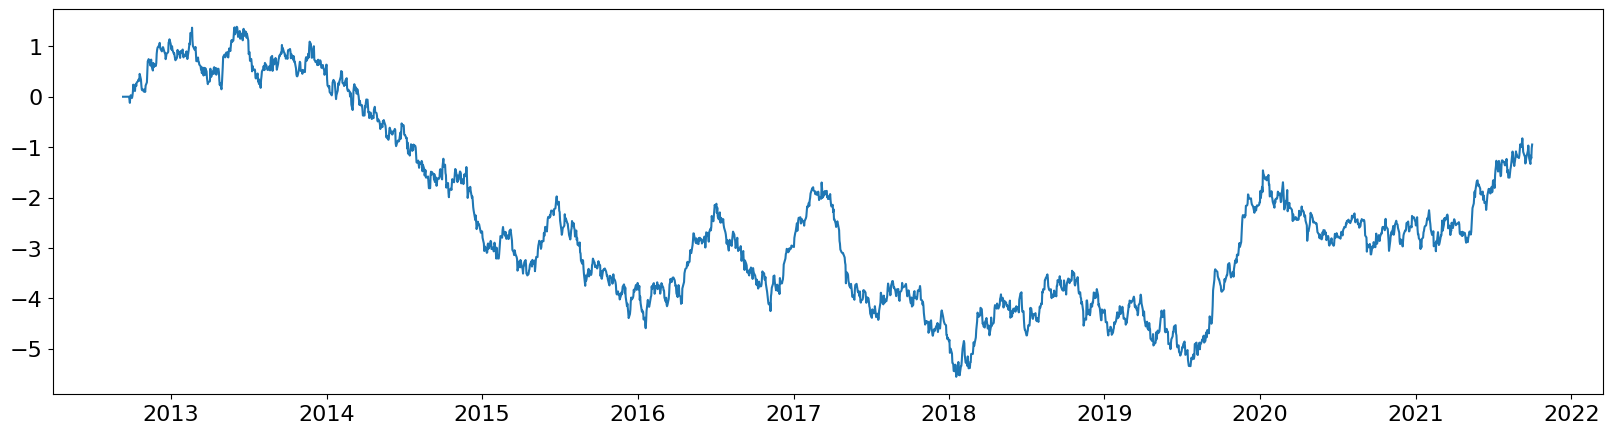

(CVXPY) Jun 23 08:09:28 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so, 0x0002): Library not loaded: @rpath/libopenblas.0.dylib\n  Referenced from: <9C513057-A15F-3038-B1F4-3597773970FC> /Users/zeegtab/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so\n  Reason: tried: '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/zeegtab/opt/anaconda3/envs/mlfinlab/bin/../lib/libopenblas.0.dylib' (no such file), '/usr/local/lib/libopenblas.0.dylib' (no such file), '/usr/lib/libopenblas.0.dylib' (no such file, not in 

2023-06-23 08:09:31.582196 100.0% apply_pt_sl_on_t1 done after 0.08 minutes. Remaining 0.0 minutes..


NameError: name 'fast_window' is not defined

In [152]:
fuel_prim_accs, fuel_accs, fuels_feat_imps = run_smac_meta_labelling_fuels(fuel_futures)

In [ ]:
plt.rcParams.update({
    "font.size": 16,
    "legend.fontsize": 14
})

In [ ]:
def plot_all_pnl_dd(accounts: list, labels: list, title: str, pnl_axs: plt.Axes.axes, dd_axs: plt.Axes.axes):

    for i in range(len(accounts)):
        pnl_axs.plot(accounts[i].curve(), label=labels[i])
        pnl_axs.legend()
        pnl_axs.title.set_text(f'Profit and Loss {title})')
        pnl_axs.set_ylabel('PnL')
        pnl_axs.set_xlabel('Time')

        dd_axs.plot(accounts[i].curve(), label=labels[i])
        dd_axs.legend()
        dd_axs.title.set_text(f'Drawdown {title})')
        dd_axs.set_ylabel('Drawdown')
        dd_axs.set_xlabel('Time')


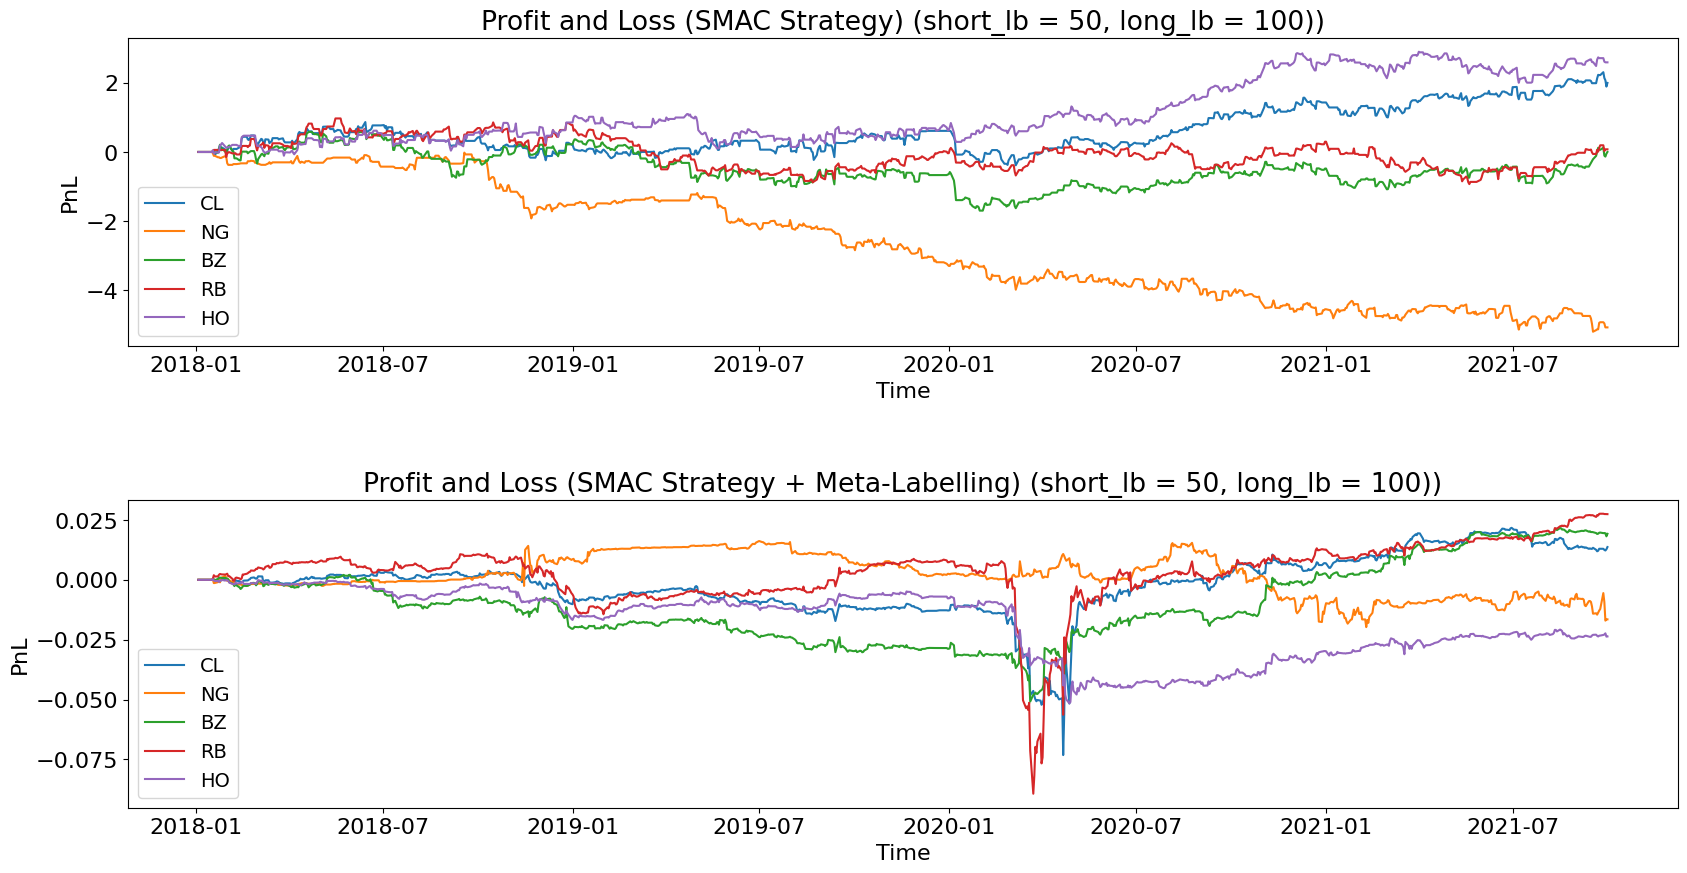

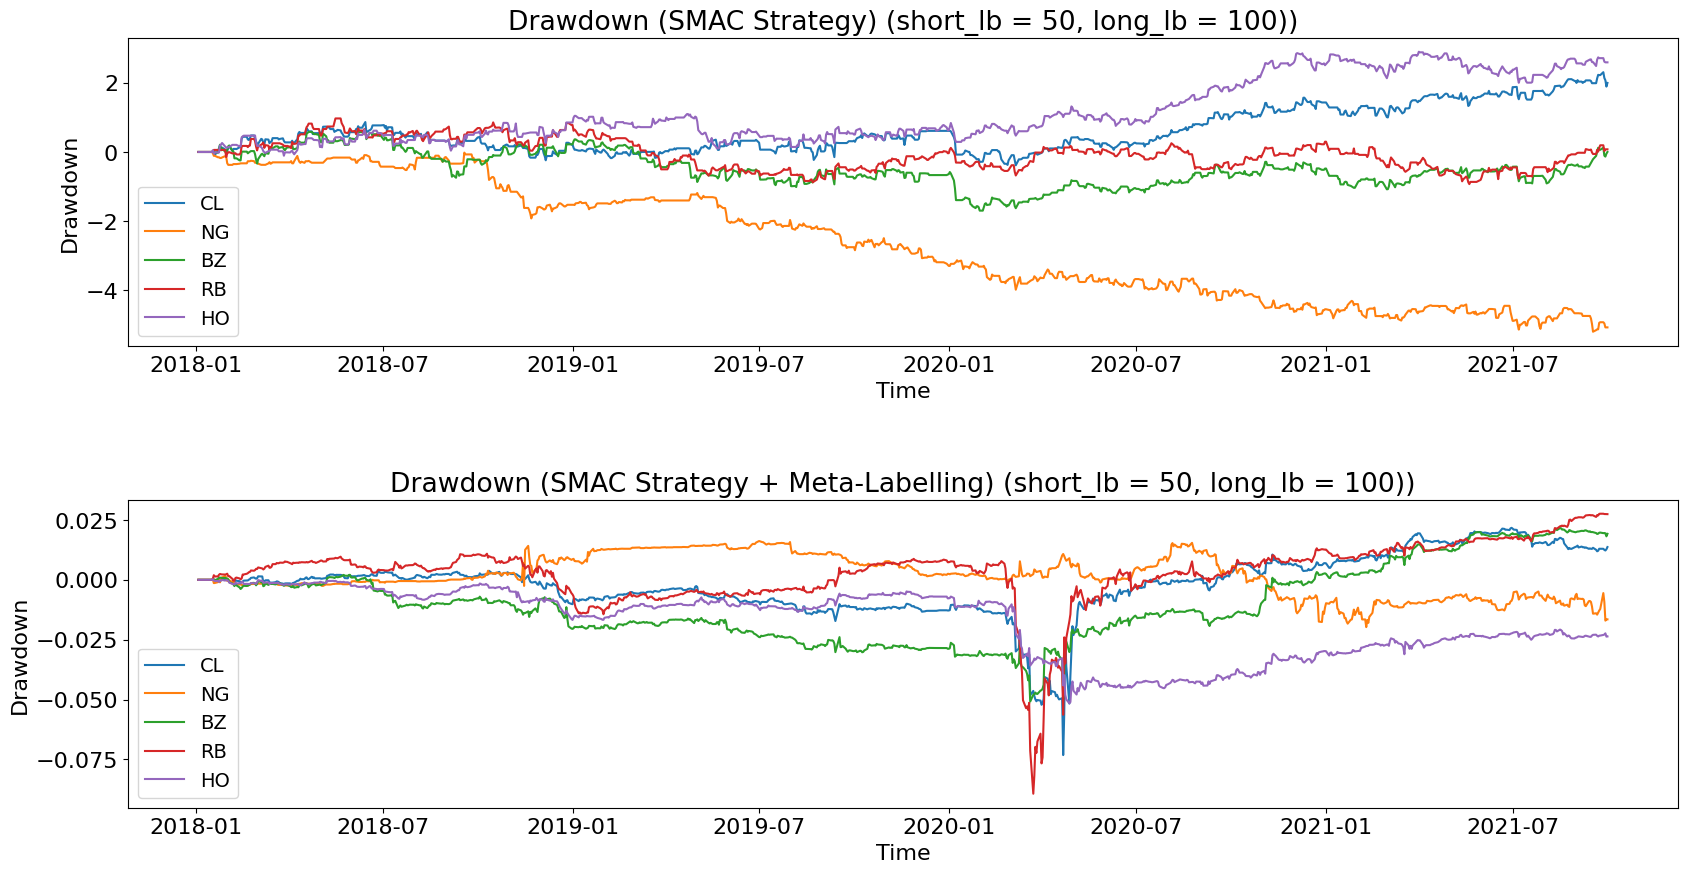

In [ ]:
SMAC_STRAT_TITLE = f'(SMAC Strategy) (short_lb = {SHORT_LB}, long_lb = {LONG_LB})'
SMAC_META_STRAT_TITLE = f'(SMAC Strategy + Meta-Labelling) (short_lb = {SHORT_LB}, long_lb = {LONG_LB})'

pnl_fig, pnl_axs = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
pnl_fig.subplots_adjust(hspace=0.5)

dd_fig, dd_axs = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
dd_fig.subplots_adjust(hspace=0.5)

plot_all_pnl_dd(fuel_prim_accs, fuel_futures, SMAC_STRAT_TITLE, pnl_axs[0], dd_axs[0])
plot_all_pnl_dd(fuel_accs, fuel_futures, SMAC_META_STRAT_TITLE, pnl_axs[1], dd_axs[1])